In [1]:
from surprise import accuracy
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
ratings = pd.read_csv("E:/intelligent programming/collaborative_filtering_recommender/notebooks/data processed_ratings.csv")

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

predictions = model.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [3]:
def get_top_n(predictions, n=10):
    '''Return top-N recommendation for each user from predictions'''
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    
    # Sort and take top-n
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

In [4]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Calculate precision and recall at K'''
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = []
    recalls = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]
        
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in top_k)
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in top_k)

        precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        precisions.append(precision)
        recalls.append(recall)
    
    return sum(precisions) / len(precisions), sum(recalls) / len(recalls)

In [5]:
precision, recall = precision_recall_at_k(predictions, k=10)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.7184
Recall: 0.5878


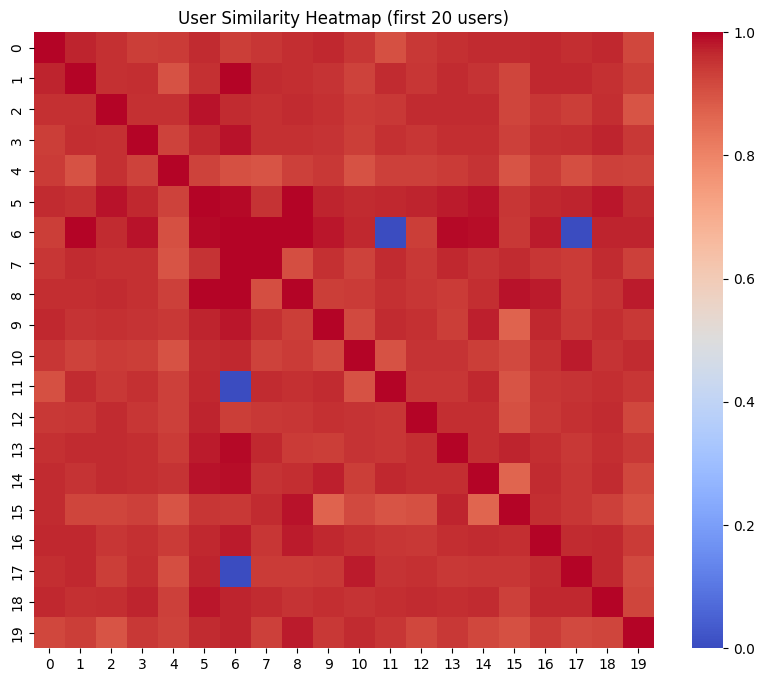

In [6]:
sim_matrix = model.sim  # cosine similarity matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(sim_matrix[:20, :20], cmap="coolwarm")
plt.title("User Similarity Heatmap (first 20 users)")
plt.show()